In [91]:
import pandas as pd
import mysql.connector
import os as os

# MySQL-Verbindung herstellen
connection_params = {
    'host': 'localhost',
    'user': 'admin',
    'password': 'Criminal1234',
    'database': 'CriminalDataDB',
    'allow_local_infile': True
}

conn = mysql.connector.connect(**connection_params)
cursor = conn.cursor()

query = "SELECT * FROM Bevoelkerungsdichte bd JOIN Bevoelkerungsdaten bvd ON bd.Gemeindename = bvd.Gemeindename AND bd.Jahr = bvd.Jahr JOIN Einkommensdaten ed ON bd.BFS_NR = ed.BFS_NR AND bd.Gemeindename = ed.Gemeindename AND bd.Jahr = ed.Jahr JOIN Finanzvermoegen fv ON bd.BFS_NR = fv.BFS_NR AND bd.Gemeindename = fv.Gemeindename AND bd.Jahr = fv.Jahr JOIN Einbrueche en ON bd.BFS_NR = en.BFS_NR AND bd.Gemeindename = en.Gemeindename AND bd.Jahr = en.Jahr"
cursor.execute(query)

# Ergebnisse abrufen und in DataFrame laden
results = cursor.fetchall()
columns = [i[0] for i in cursor.description]
df = pd.DataFrame(results, columns=columns)

# Verbindung schließen
cursor.close()
conn.close()

# Nehmen wir an, df ist dein DataFrame
# Hier sind die Spalten mit Duplikaten
duplicated_columns = ['Gemeindename', 'Jahr', 'BFS_NR']

# Verwende die Methode loc, um die Duplikate zu entfernen und nur die ersten Instanzen zu behalten
df_unique = df.loc[:, ~df.columns.duplicated()]

# Zürich-Daten filtern
zurich_data = df_unique[df_unique['Gemeindename'] == 'Zürich']

# Einbruchdiebstahl-Daten summieren und andere Spalten beibehalten
zurich_summed = zurich_data.groupby(['Jahr']).agg({
    'Einbruchdiebstahl_Total': 'sum',
    'Einschleichdiebstahl_Total': 'sum',
    'Einbruchdiebstahl_Versucht': 'sum',
    'Einschleichdiebstahl_Versucht': 'sum',
    'Einbruchdiebstahl_Vollendet': 'sum',
    'Einschleichdiebstahl_Vollendet': 'sum',
    'BFS_NR': 'first',
    'Gemeindename': 'first',
    'Einwohner_pro_Quadratkilometer': 'first',
    'Einwohner 0-14 Jahre alt': 'first',
    'Einwohner 15-29 Jahre alt': 'first',
    'Einwohner 30-44 Jahre alt': 'first',
    'Einwohner 45-59 Jahre alt': 'first',
    'Einwohner 60-74 Jahre alt': 'first',
    'Einwohner 75-89 Jahre alt': 'first',
    'Einwohner 90-104 Jahre alt': 'first',
    'durchschnittliches_steuerbares_Einkommen_pro_Einwohner': 'first',
    'Finanzvermoegen_pro_Einwohner': 'first',
    'Einwohner': 'sum'
}).reset_index()

# Neue summierte Zeilen für Zürich zum DataFrame hinzufügen und vorhandene Zeilen ersetzen
df_unique = df_unique[df_unique['Gemeindename'] != 'Zürich']  # Vorhandene Zürich-Zeilen entfernen
df_unique = pd.concat([df_unique, zurich_summed], ignore_index=True)  # Summierte Zeilen hinzufügen

# Ergebnis anzeigen
print(df_unique)


      BFS_NR Gemeindename  Jahr  Einwohner_pro_Quadratkilometer  \
0        131     Adliswil  2010                          2113.8   
1        131     Adliswil  2011                          2240.0   
2        131     Adliswil  2012                          2307.3   
3        131     Adliswil  2013                          2335.4   
4        131     Adliswil  2014                          2356.5   
...      ...          ...   ...                             ...   
2054     261       Zürich  2018                          4707.8   
2055     261       Zürich  2019                          4765.8   
2056     261       Zürich  2020                          4787.2   
2057     261       Zürich  2021                          4802.1   
2058     261       Zürich  2022                          4855.4   

      Einwohner 0-14 Jahre alt  Einwohner 15-29 Jahre alt  \
0                         2348                       2907   
1                         2510                       3087   
2           

Genauigkeit des Random Forest-Modells: 0.9975728155339806


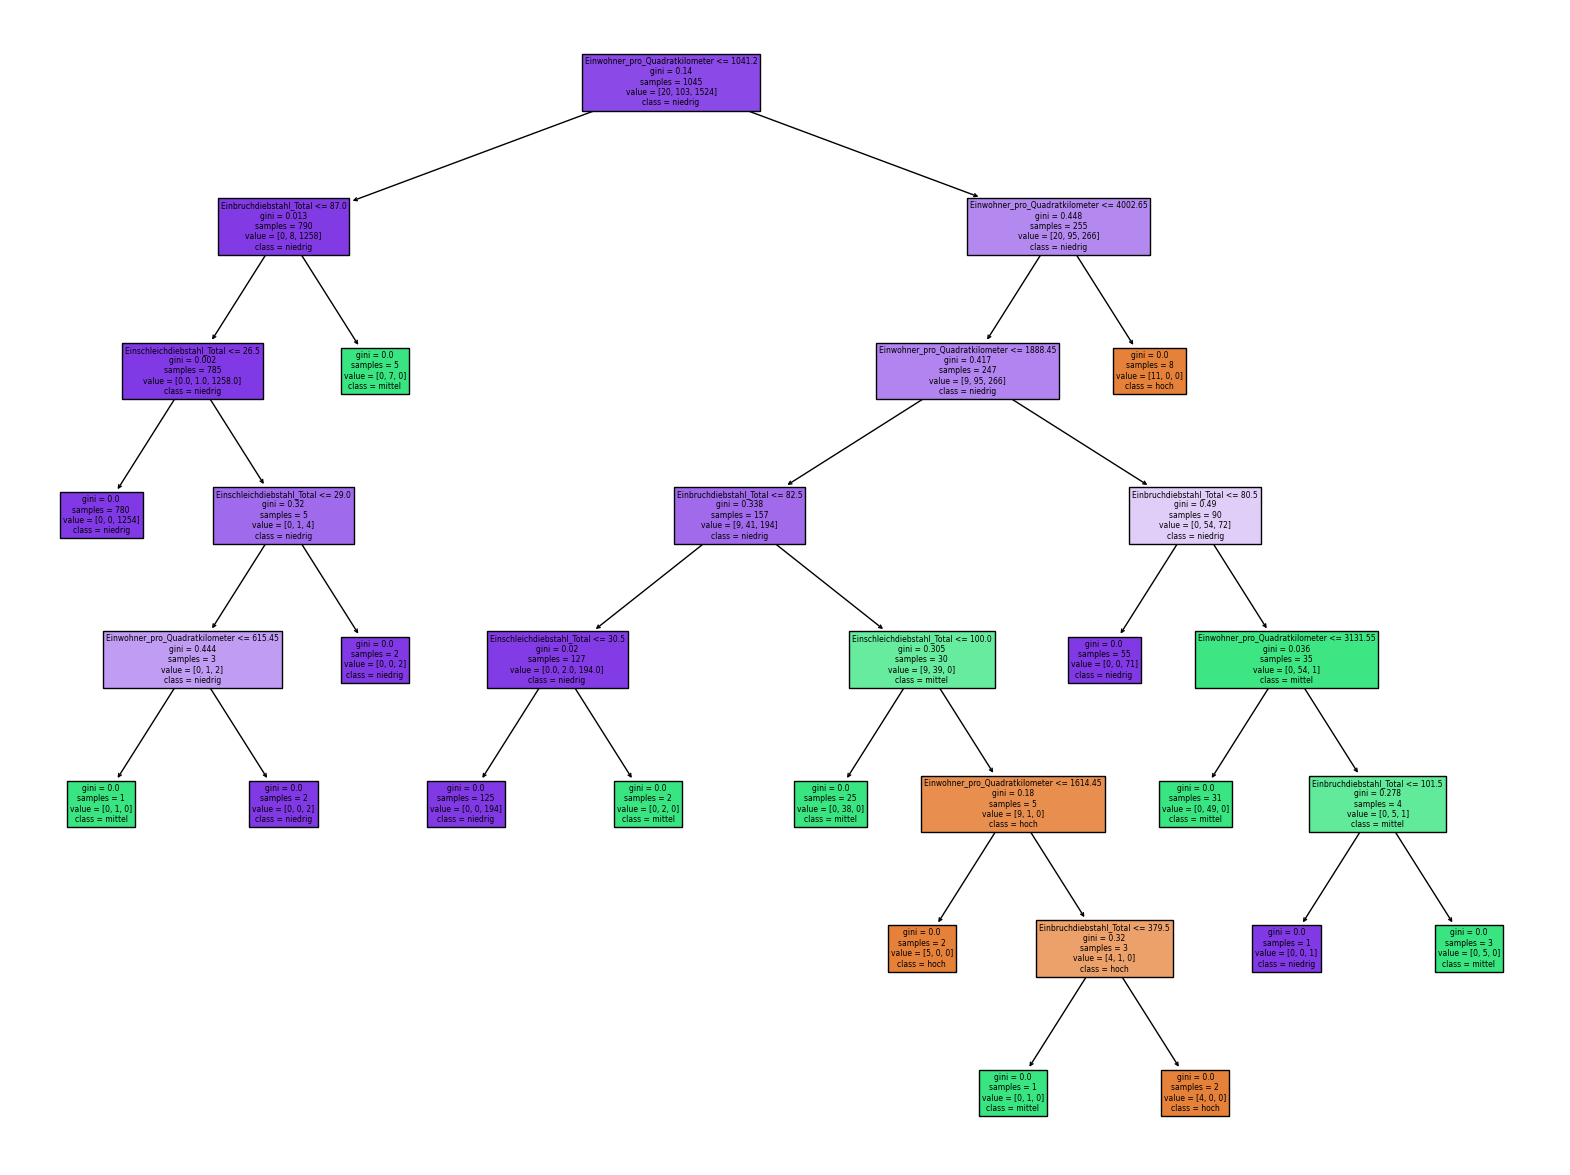

In [92]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import matplotlib.pyplot as plt
from sklearn.tree import plot_tree
import seaborn as sns


features = ['Einwohner_pro_Quadratkilometer',  
            'Einbruchdiebstahl_Total', 
            'Einschleichdiebstahl_Total']

total_crime = df_unique['Einbruchdiebstahl_Total'] + df_unique['Einschleichdiebstahl_Total']
df_unique['Kriminalitätsrisiko'] = pd.cut(total_crime, bins=[-float("inf"), 100, 500, float("inf")], labels=["niedrig", "mittel", "hoch"])

target = 'Kriminalitätsrisiko'

X = df_unique[features]
y = df_unique[target]

# Aufteilung der Daten in Trainings- und Testsets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Random Forest-Modell erstellen und trainieren
random_forest = RandomForestClassifier(n_estimators=100, random_state=42)
random_forest.fit(X_train, y_train)

# Vorhersagen für das Testset machen
y_pred_random_forest = random_forest.predict(X_test)

# Genauigkeit des Random Forest-Modells bewerten
accuracy_random_forest = accuracy_score(y_test, y_pred_random_forest)
print("Genauigkeit des Random Forest-Modells:", accuracy_random_forest)

# Entscheidungsbaum visualisieren
plt.figure(figsize=(20, 15))
plot_tree(random_forest.estimators_[0], feature_names=features, class_names=random_forest.classes_, filled=True)
plt.show()

In [93]:
# Vorhersagen für den gesamten Datensatz machen
all_predictions = random_forest.predict(X)

# DataFrame mit den Gemeinden und ihren Vorhersagen erstellen
df_predictions = pd.DataFrame({'Gemeindename': df_unique['Gemeindename'], 'Kriminalitätsrisiko': all_predictions})

# Gemeinden mit hohem, mittlerem und niedrigem Kriminalitätsrisiko filtern
high_risk_communities = df_predictions[df_predictions['Kriminalitätsrisiko'] == 'hoch']
medium_risk_communities = df_predictions[df_predictions['Kriminalitätsrisiko'] == 'mittel']
low_risk_communities = df_predictions[df_predictions['Kriminalitätsrisiko'] == 'niedrig']

# Ausgabe der Gemeinden nach Risikokategorien
print("Gemeinden mit hohem Kriminalitätsrisiko:")
print(high_risk_communities)

print("\nGemeinden mit mittlerem Kriminalitätsrisiko:")
print(medium_risk_communities)

print("\nGemeinden mit niedrigem Kriminalitätsrisiko:")
print(low_risk_communities)


Gemeinden mit hohem Kriminalitätsrisiko:
     Gemeindename Kriminalitätsrisiko
1279   Winterthur                hoch
1280   Winterthur                hoch
1281   Winterthur                hoch
1282   Winterthur                hoch
1283   Winterthur                hoch
1284   Winterthur                hoch
1285   Winterthur                hoch
1287   Winterthur                hoch
1336   Winterthur                hoch
1509   Winterthur                hoch
2046       Zürich                hoch
2047       Zürich                hoch
2048       Zürich                hoch
2049       Zürich                hoch
2050       Zürich                hoch
2051       Zürich                hoch
2052       Zürich                hoch
2053       Zürich                hoch
2054       Zürich                hoch
2055       Zürich                hoch
2056       Zürich                hoch
2057       Zürich                hoch
2058       Zürich                hoch

Gemeinden mit mittlerem Kriminalitätsrisiko:
 


Präzision:
 0.9975792536890629

Recall:
 0.9975728155339806

F1-Score:
 0.9975538578503714


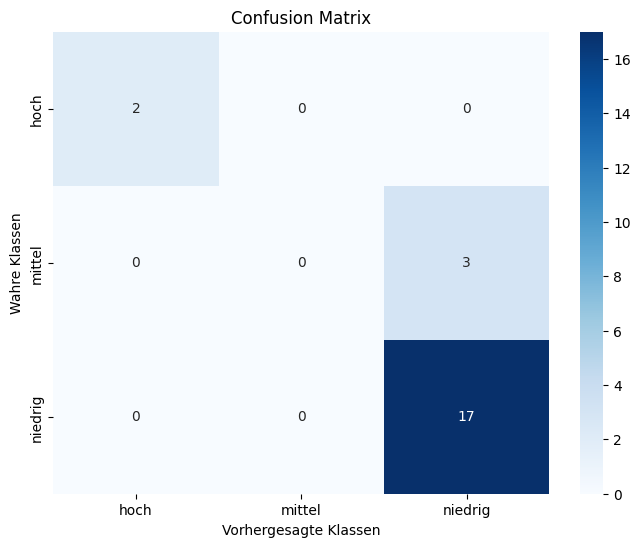

In [94]:
# Präzision, Recall und F1-Score berechnen
precision = precision_score(y_test, y_pred_random_forest, average='weighted')
recall = recall_score(y_test, y_pred_random_forest, average='weighted')
f1 = f1_score(y_test, y_pred_random_forest, average='weighted')

print("\nPräzision:\n", precision)
print("\nRecall:\n", recall)
print("\nF1-Score:\n", f1)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=random_forest.classes_, yticklabels=random_forest.classes_)
plt.xlabel('Vorhergesagte Klassen')
plt.ylabel('Wahre Klassen')
plt.title('Confusion Matrix')
plt.show()



Genauigkeit (Accuracy): Die Genauigkeit des Modells beträgt 99.76%. Dies bedeutet, dass das Modell in etwa 99.76% der Fälle korrekt vorhersagt, zu welcher Klasse eine Gemeinde bezüglich ihres Kriminalitätsrisikos gehört.

Präzision (Precision): Die Präzision beträgt 99.76%. Präzision misst das Verhältnis der korrekt vorhergesagten positiven Fälle zu allen vorhergesagten positiven Fällen. In diesem Fall bedeutet es, dass von den als "niedrig", "mittel" oder "hoch" klassifizierten Gemeinden etwa 99.76% tatsächlich korrekt klassifiziert wurden.

Recall (Rückruf/Sensitivität): Der Recall beträgt ebenfalls 99.76%. Recall misst das Verhältnis der korrekt vorhergesagten positiven Fälle zu allen tatsächlich positiven Fällen. In diesem Fall bedeutet es, dass etwa 99.76% der tatsächlich als "niedrig", "mittel" oder "hoch" klassifizierten Gemeinden korrekt erkannt wurden.

F1-Score: Der F1-Score, der das harmonische Mittel aus Präzision und Recall ist, beträgt 99.76%. Ein hoher F1-Score deutet darauf hin, dass das Modell sowohl eine hohe Präzision als auch einen hohen Recall aufweist, was auf eine ausgewogene Leistung bei der Klassifizierung hinweist.

Confusion Matrix: Die Confusion Matrix zeigt die Anzahl der Vorhersagen für jede Klasse im Vergleich zu den tatsächlichen Klassen. In diesem Fall können wir sehen, dass das Modell nur sehr wenige falsche Vorhersagen gemacht hat, wie durch die geringe Anzahl von Fehlern in der Matrix angezeigt wird.

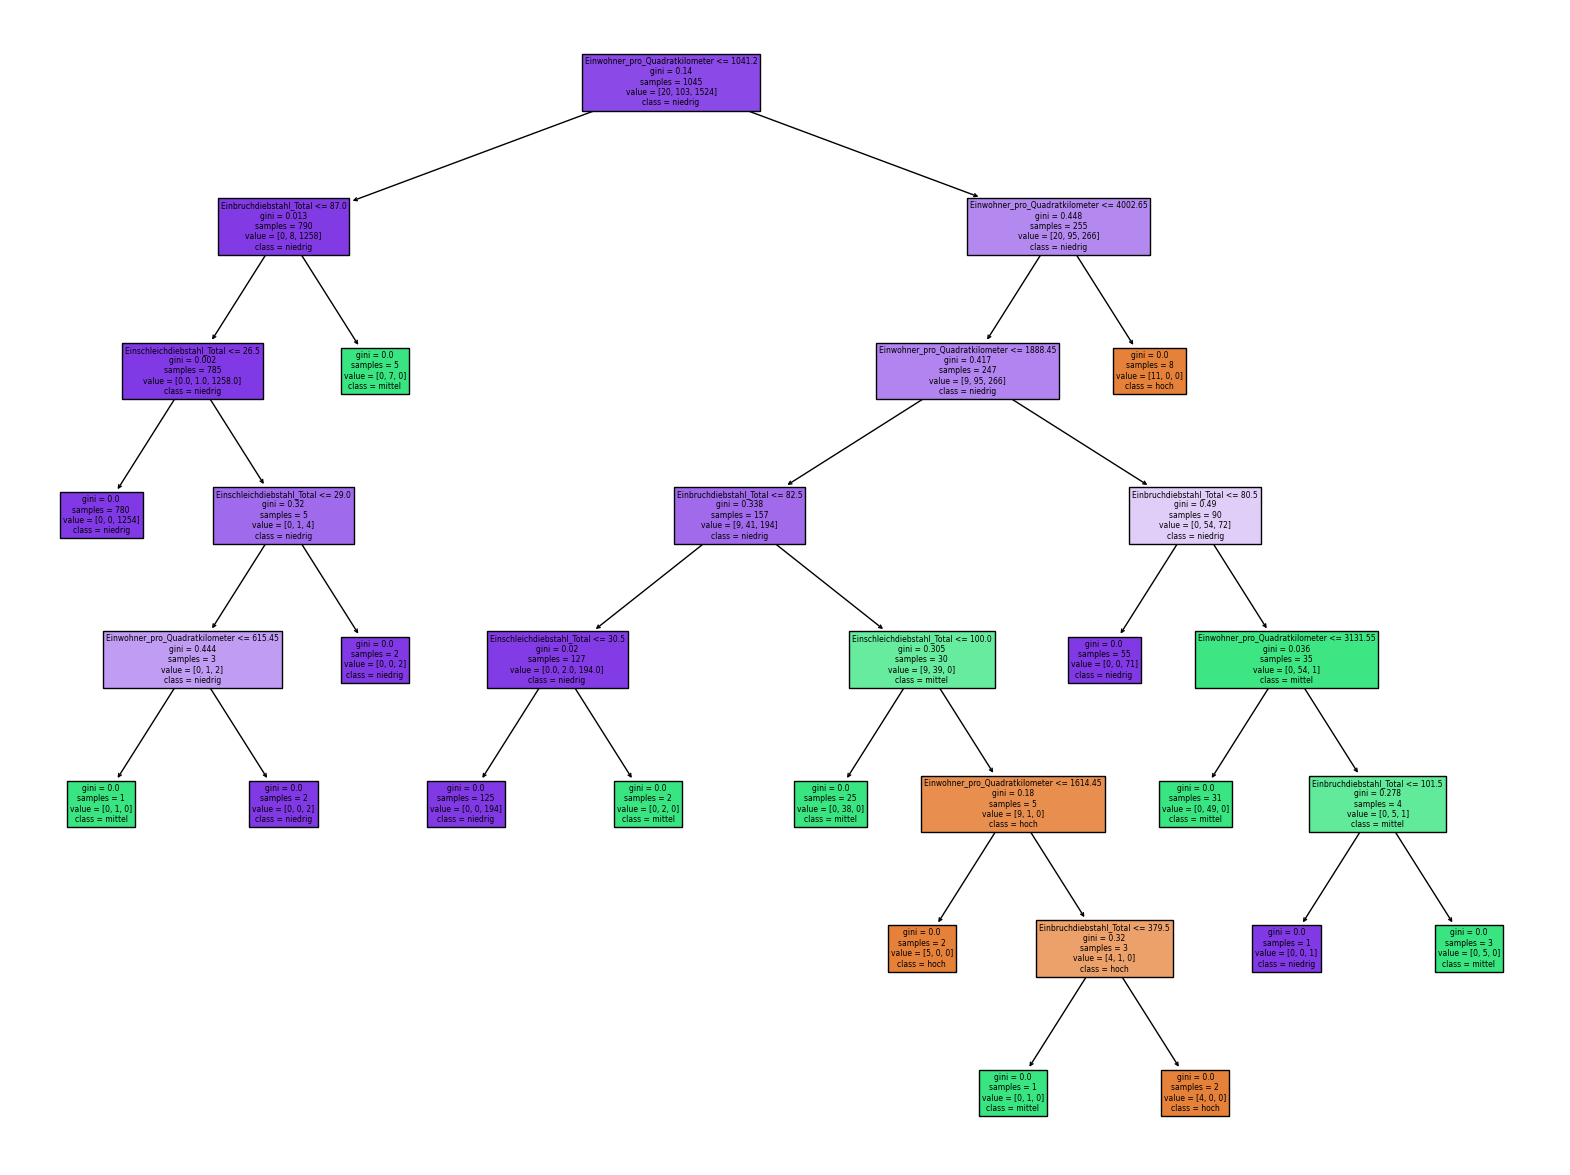

Vorhersagen für die neuen Daten:
['niedrig' 'niedrig' 'niedrig' 'niedrig' 'niedrig' 'niedrig' 'niedrig'
 'niedrig' 'niedrig' 'niedrig' 'niedrig' 'niedrig' 'niedrig' 'niedrig'
 'niedrig' 'niedrig' 'niedrig' 'niedrig' 'niedrig' 'niedrig' 'hoch' 'hoch']

Genauigkeit auf den neuen Daten:
 0.8636363636363636

Präzision auf den neuen Daten:
 0.7477272727272727

Recall auf den neuen Daten:
 0.8636363636363636

F1-Score auf den neuen Daten:
 0.800982800982801


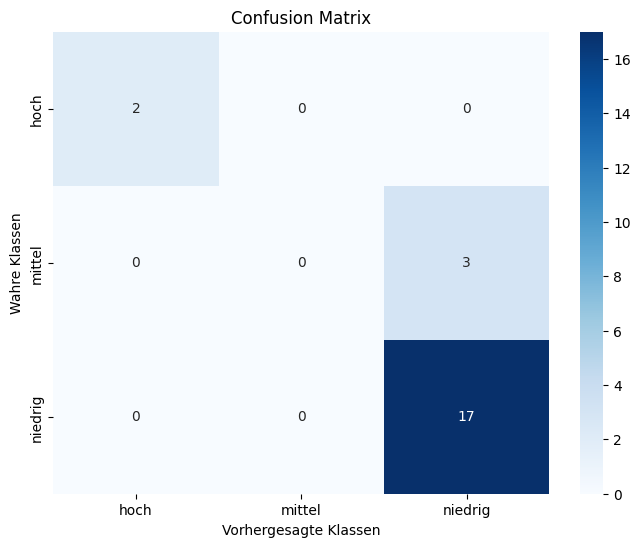

In [95]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import matplotlib.pyplot as plt
from sklearn.tree import plot_tree

# Features auswählen
features = ['Einwohner_pro_Quadratkilometer', 'Einbruchdiebstahl_Total', 'Einschleichdiebstahl_Total']

# Kriminalitätsrisiko berechnen
total_crime = df_unique['Einbruchdiebstahl_Total'] + df_unique['Einschleichdiebstahl_Total']
df_unique['Kriminalitätsrisiko'] = pd.cut(total_crime, bins=[-float("inf"), 100, 500, float("inf")], labels=["niedrig", "mittel", "hoch"])

# Zielvariable definieren
target = 'Kriminalitätsrisiko'

# Feature-Matrix X und Zielvektor y erstellen
X = df_unique[features]
y = df_unique[target]

# Aufteilung der Daten in Trainings- und Testsets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Random Forest-Modell erstellen und trainieren
random_forest = RandomForestClassifier(n_estimators=100, random_state=42)
random_forest.fit(X_train, y_train)

# Vorhersagen für das Testset machen
y_pred_random_forest = random_forest.predict(X_test)

# Entscheidungsbaum visualisieren (nur ein Baum)
plt.figure(figsize=(20, 15))
plot_tree(random_forest.estimators_[0], feature_names=features, class_names=random_forest.classes_, filled=True)
plt.show()

# Neue Daten für Vorhersagen erstellen
new_data = pd.DataFrame({
    'Einwohner_pro_Quadratkilometer': [1800, 2200, 1900, 2100, 2300, 1700, 2000, 2400, 2500, 1600, 
                                        1850, 1950, 2050, 2150, 2250, 2350, 2450, 2550, 1650, 1750, 5600, 7800],  
    'Einbruchdiebstahl_Total': [45, 55, 60, 35, 40, 30, 50, 65, 70, 25,
                                 48, 58, 63, 37, 42, 32, 52, 67, 72, 27, 2000, 1400],                
    'Einschleichdiebstahl_Total': [8, 12, 15, 6, 10, 5, 9, 13, 16, 4, 
                                    9, 11, 14, 7, 11, 6, 10, 14, 17, 3, 88, 190]
})

# Vorhersagen für die neuen Daten machen
new_data_predictions = random_forest.predict(new_data)

# Ausgabe der Vorhersagen
print("Vorhersagen für die neuen Daten:")
print(new_data_predictions)

# Bewertung des Modells auf den neuen Daten
new_data_true_labels = ['niedrig', 'niedrig', 'niedrig', 'niedrig', 'niedrig', 'niedrig', 'niedrig',
                        'niedrig', 'mittel', 'niedrig', 'niedrig', 'niedrig', 'niedrig', 'niedrig',
                        'niedrig', 'niedrig', 'mittel', 'mittel', 'niedrig', 'niedrig', 'hoch', 'hoch']  # True labels für die neuen Daten (Beispiel)
new_data_accuracy = accuracy_score(new_data_true_labels, new_data_predictions)
new_data_precision = precision_score(new_data_true_labels, new_data_predictions, average='weighted', zero_division=0)
new_data_recall = recall_score(new_data_true_labels, new_data_predictions, average='weighted')
new_data_f1 = f1_score(new_data_true_labels, new_data_predictions, average='weighted')

print("\nGenauigkeit auf den neuen Daten:\n", new_data_accuracy)
print("\nPräzision auf den neuen Daten:\n", new_data_precision)
print("\nRecall auf den neuen Daten:\n", new_data_recall)
print("\nF1-Score auf den neuen Daten:\n", new_data_f1)


# Confusion Matrix erstellen für die neuen Datensätze
conf_matrix = confusion_matrix(new_data_true_labels, new_data_predictions)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=random_forest.classes_, yticklabels=random_forest.classes_)
plt.xlabel('Vorhergesagte Klassen')
plt.ylabel('Wahre Klassen')
plt.title('Confusion Matrix')
plt.show()

Genauigkeit: Die Genauigkeit misst den Prozentsatz der korrekten Vorhersagen im Verhältnis zur Gesamtzahl der Vorhersagen. In diesem Fall beträgt die Genauigkeit 0.8636, was bedeutet, dass das Modell etwa 86,36 % der Vorhersagen korrekt gemacht hat.

Präzision: Die Präzision misst den Prozentsatz der korrekten positiven Vorhersagen im Verhältnis zur Gesamtzahl der positiven Vorhersagen (korrekte positive und falsche positive). Hier beträgt die Präzision 0.7477, was bedeutet, dass von den positiven Vorhersagen etwa 74,77 % tatsächlich korrekt sind.

Recall: Der Recall (auch True Positive Rate genannt) misst den Prozentsatz der korrekt vorhergesagten positiven Instanzen im Verhältnis zur Gesamtzahl der tatsächlich positiven Instanzen. Er beträgt hier 0.8636, was bedeutet, dass das Modell etwa 86,36 % der tatsächlich positiven Instanzen korrekt vorhergesagt hat.

F1-Score: Der F1-Score ist das harmonische Mittel zwischen Präzision und Recall und bietet eine ausgewogene Bewertung zwischen ihnen. Er beträgt 0.8010, was zeigt, dass das Modell eine gute Balance zwischen Präzision und Recall aufweist.

/Users/natalievintonjak/anaconda3/envs/adsenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/natalievintonjak/anaconda3/envs/adsenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/natalievintonjak/anaconda3/envs/adsenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/natalievintonjak/anaconda3/envs/adsenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/natalievinton

Vorhersage für Zürich für die nächsten 5 Jahre: 13    2180.661907
14    2328.870323
15    2364.782835
16    2352.506687
17    2284.650983
Name: predicted_mean, dtype: float64


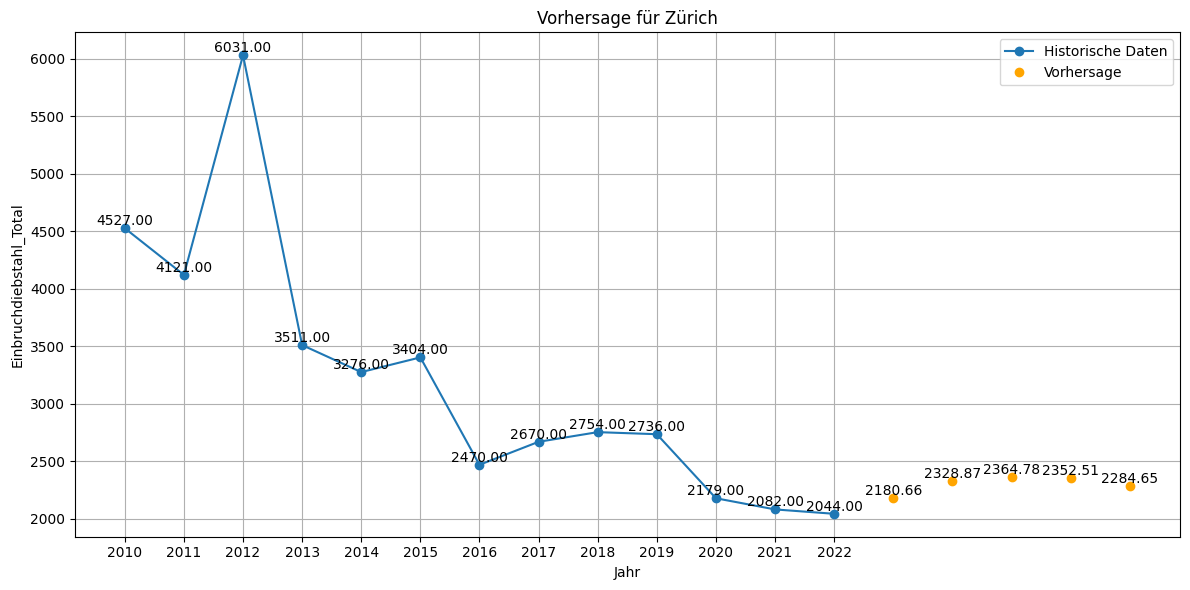

In [103]:
import pandas as pd
from statsmodels.tsa.arima.model import ARIMA
import matplotlib.pyplot as plt

# Zürich-Daten filtern
zurich_data = df_unique[df_unique['Gemeindename'] == 'Zürich']

# Einbruchdiebstahl-Daten für Zürich vorbereiten
time_series = zurich_data.set_index('Jahr')['Einbruchdiebstahl_Total']

# Funktion zur Vorhersage mit ARIMA
def arima_forecast(data, order, steps):
    model = ARIMA(data, order=order)
    model_fit = model.fit()
    forecast = model_fit.forecast(steps=steps)
    return forecast

# Parameter für ARIMA-Modell
n_steps = 5  # Anzahl der Jahre für die Vorhersage
order = (5, 1, 0)  # ARIMA-Modellordnung

# Vorhersagen treffen
forecast = arima_forecast(time_series, order, n_steps)

# Ergebnisse anzeigen
print("Vorhersage für Zürich für die nächsten", n_steps, "Jahre:", forecast)

# Jahre für die x-Achse extrahieren
last_year = time_series.index[-1]
forecast_years = range(last_year + 1, last_year + n_steps + 1)

# Vorhandene Jahre (Historie)
existing_years = time_series.index

# Vorhersagen visualisieren
plt.figure(figsize=(12, 6))  # Breite und Höhe des Plots festlegen

# Historische Daten plotten
plt.plot(existing_years, time_series.values, label='Historische Daten', marker='o')

# Vorhersage plotten
plt.plot(forecast_years, forecast, 'o', label='Vorhersage', color='orange')

plt.xlabel('Jahr')
plt.ylabel('Einbruchdiebstahl_Total')
plt.title('Vorhersage für Zürich')
plt.xticks(range(int(time_series.index.min()), int(time_series.index.max()) + 1))  # Ganzzahlige X-Achsenbeschriftungen
plt.legend()
plt.grid(True)  # Gitter hinzufügen
plt.tight_layout()  # Automatische Anpassung der Layoutabmessungen

# Beschriftungen innerhalb des Plots hinzufügen (Historische Daten)
for year, value in zip(existing_years, time_series.values):
    plt.text(year, value, f'{value:.2f}', ha='center', va='bottom')

# Beschriftungen innerhalb des Plots hinzufügen (Vorhersage)
for year, value in zip(forecast_years, forecast):
    plt.text(year, value, f'{value:.2f}', ha='center', va='bottom')

plt.show()
